### Final Collaborative Recommender

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Recommendation Model

In [7]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from sklearn.metrics import mean_squared_error
from math import sqrt
import nltk
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


#this is our final recomendation mode...here we used both content and colaborative model to recomend dishes

In [5]:
class Recommender:
    
    def __init__(self, vanilla=False):
        self.vanilla = vanilla
        self.df = pd.read_csv('/content/drive/MyDrive/project/Data_Recommendation/dataset.csv')
        self.profiles = pd.read_csv('/content/drive/MyDrive/project/Data_Recommendation/user_profiles.csv')
        self.recent_activity = pd.read_csv('/content/drive/MyDrive/project/Data_Recommendation/recent_activity.csv')
    
    def get_features(self,dataframe):
        #getting dummies of dataset
        nutrient_dummies = dataframe.nutrient.str.get_dummies(sep=' ')
        disease_dummies = dataframe.disease.str.get_dummies(sep=' ')
        diet_dummies = dataframe.diet.str.get_dummies(sep=' ')
        feature_df = pd.concat([nutrient_dummies,disease_dummies,diet_dummies],axis=1)
        return feature_df
## This method takes a DataFrame as input and processes the columns nutrient, disease, and diet by creating dummy variables for each unique value. 
## The resulting DataFrame contains these dummy variables as features. It returns the processed DataFrame.

    
    def find_neighbors(self, dataframe, features, k):
        features_df = self.get_features(dataframe)
        total_features = features_df.columns  
        d = dict()
        for i in total_features:
            d[i]= 0
        for i in features:
            d[i] = 1
        final_input = list(d.values())
        
        similar_neighbors = self.k_neighbor([final_input],features_df,dataframe,k)
        return similar_neighbors
## find_neighbors(self, dataframe, features, k): Given a DataFrame, a list of features, and the number of neighbors to find (k), 
## this method converts the features into a binary dictionary and creates a list of 1s and 0s corresponding to the presence or absence of each feature. 
## It then calls the k_neighbor method, passing the feature vectors and the DataFrame, to find the k nearest neighbors based on the features. 
## It returns the DataFrame of similar neighbors.
    
    def k_neighbor(self,inputs,feature_df,dataframe,k):
        
        #initializing model with k neighbors
        model = NearestNeighbors(n_neighbors=k,algorithm='ball_tree')

        if self.vanilla:
          model = NearestNeighbors()
        
        # fitting model with dataset features
        model.fit(feature_df)
        
        df_results = pd.DataFrame(columns=list(dataframe.columns))
        
        # getting distance and indices for k nearest neighbor
        distnaces , indices = model.kneighbors(inputs)

        for i in list(indices):
            df_results = df_results.append(dataframe.loc[i])

        df_results = df_results.reset_index(drop=True)
        return df_results
## k_neighbor(self, inputs, feature_df, dataframe, k): This method initializes a NearestNeighbors model with k neighbors and fits it with the feature DataFrame. 
## It then uses the model to find the k nearest neighbors for the given feature inputs. The resulting indices are used to retrieve the corresponding rows from the original DataFrame (dataframe). 
## The retrieved DataFrame is returned as the results.
    
    def user_based(self,features,user_id, max_count):
       
        similar_users = self.find_neighbors(self.profiles,features, max_count)
        users = list(similar_users.user_id)

        results = self.recent_activity[self.recent_activity.user_id.isin(users)] #taking acitivies
   
        results = results[results['user_id']!=user_id] # selecting those which are not reviewed by user
 
        meals = list(results.meal_id.unique())
      
        results = self.df[self.df.meal_id.isin(meals)]
    
        results = results.filter(['meal_id','name','nutrient','veg_nonveg','description','price','review'])

        results = results.drop_duplicates(subset=['name'])
        results = results.reset_index(drop=True)
        return results
## user_based(self, features, user_id, max_count): This method finds similar users based on the provided features by calling the find_neighbors method on the profiles DataFrame. 
## It then retrieves recent activities from the recent_activity DataFrame for those similar users, filters out activities reviewed by the current user, and selects the meals associated with those activities from the df DataFrame. 
## The relevant columns are extracted, duplicates are removed, and the resulting DataFrame is returned.

        
    def recent_activity_based(self,user_id, max_count):
        recent_df = self.recent_activity[self.recent_activity['user_id']==user_id]
        meal_ids = list(recent_df.meal_id.unique())
        recent_data = self.df[self.df.meal_id.isin(meal_ids)][['nutrient','category','disease','diet']].reset_index(drop=True)

        nutrient = []
        disease = []
        diet = []
        
        for i in range(recent_data.shape[0]):
            for j in recent_data.loc[i,'nutrient'].split():
                nutrient.append(j)
        for i in range(recent_data.shape[0]):
            for j in recent_data.loc[i,'disease'].split():
                disease.append(j)
        for i in range(recent_data.shape[0]):
            for j in recent_data.loc[i,'diet'].split():
                diet.append(j)
        
        features = []

        a = dict(Counter(nutrient))
        m = np.mean(list(a.values()))
        for i in a.items():
            if i[1]>m:
                features.append(i[0])
        

        a = dict(Counter(disease))
        m = np.mean(list(a.values()))
        for i in a.items():
            if i[1]>m:
                features.append(i[0])
        
        a = dict(Counter(diet))
        m = np.mean(list(a.values()))
        for i in a.items():
            if i[1]>m:
                features.append(i[0])
                
        similar_neighbors = self.find_neighbors(self.df,features, max_count)
        return similar_neighbors.filter(['meal_id','name','nutrient','veg_nonveg', 'diet', 'disease', 'description','price','review'])
## recent_activity_based(self, user_id, max_count): This method retrieves the recent activities of a given user from the recent_activity DataFrame. 
## It extracts the nutrients, diseases, and diets associated with the meals in the activities and calculates the features based on the occurrence of each attribute. 
## It then calls the find_neighbors method on the df DataFrame to find similar meals based on these features. The resulting DataFrame is returned.

        
    def recommend(self,user_id, max_count):
        #finding user's profile features by id
        profile = self.profiles[self.profiles['user_id']==user_id]
        features = []
        features.extend(profile['nutrient'].values[0].split())
        features.extend(profile['disease'].values[0].split())
        features.extend(profile['diet'].values[0].split())
        df1 = self.user_based(features,user_id, max_count)
 
        df2 = self.recent_activity_based(user_id, max_count)
        df = pd.concat([df1,df2])
      
        df = df.drop_duplicates('meal_id').reset_index(drop=True)
        return df.dropna()
    
    

## recommend(self, user_id, max_count): This method combines the recommendations from the user_based and recent_activity_based methods. 
## It first retrieves the features from the user's profile and calls user_based to get user-based recommendations. 
## It then calls recent_activity_based to get recommendations based on recent activity. 
##The results from both methods are concatenated, duplicates are removed, and the final DataFrame is returned.

### Prediction

In [6]:
user_id = 50

ob_vanilla = Recommender(vanilla=True)
result_vanilla = ob_vanilla.recommend(f'user_{user_id}', 15)

ob = Recommender()
result = ob.recommend(f'user_{user_id}', 15)
result

,meal_id,name,nutrient,veg_nonveg,description,price,diet,disease
5,meal_id_262,Veg Summer Rolls,carbohydrates,veg,https://food.ndtv.com/recipe-veg-summer-rolls-...,585,ketogenic_diet,heart_disease diabeties
6,meal_id_424,Carrot Halwa With Mango Bavarin,fiber,veg,https://food.ndtv.com/recipe-carrot-halwa-with...,505,high_fiber_diet,pregnancy hypertension
7,meal_id_251,Warm Apple &amp; Kinnu Winter Punch,carbohydrates,veg,https://food.ndtv.com/recipe-warm-apple-kinnu-...,630,high_protien_diet,hypertension diabeties
8,meal_id_408,Shahi Gulaab &amp; Thandai Bon Bons,magnesium,veg,https://food.ndtv.com/recipe-shahi-gulaab-than...,460,high_protien_diet,hypertension goitre diabeties
9,meal_id_455,Homemade Snickers Bar,carbohydrates,veg,https://food.ndtv.com/recipe-homemade-snickers...,265,low_sodium_diet high_fiber_diet,heart_disease diabeties
10,meal_id_291,Moongfali Til Laddoo,magnesium copper,veg,https://food.ndtv.com/recipe-moongfali-til-lad...,340,high_protien_diet,hypertension goitre diabeties
11,meal_id_311,Grilled Almond Barfi (Sugar Free),carbohydrate,veg,https://food.ndtv.com/recipe-grilled-almond-bu...,575,mediterranean_diet gluten_free_diet omni_diet ...,diabeties
12,meal_id_574,Crazy Stupid Smoothie,selenium,veg,https://food.ndtv.com/recipe-crazy-stupid-smoo...,560,high_protien_diet type_a_diet ketogenic_diet,pregnancy goitre
13,meal_id_533,Strawberry Frozen Margarita,vitamin_c,veg,https://food.ndtv.com/recipe-strawberry-frozen...,645,dash_diet high_fiber_diet low_sodium_diet vega...,scurvy
14,meal_id_540,Chamomile And Lavender Tea,manganese,veg,https://food.ndtv.com/recipe-chamomile-and-lav...,335,high_protien_diet low_fat_diet high_fiber_diet...,kidney_disease heart_disease


### Evaluation


Mean Absolute Error of nutrient attributes        : 7.00%
Mean Absolute Error of diet attributes            : 1.60%
Mean Absolute Error of disease attributes         : 0.78%

Root Mean Squared Error of nutrient attributes    : 9.66%
Root Mean Squared Error of diet attributes        : 3.00%
Root Mean Squared Error of disease attributes     : 1.20%


Mean Absolute Error of nutrient attributes (Vanilla): 11.00%
Mean Absolute Error of diet attributes (Vanilla)  : 5.50%
Mean Absolute Error of disease attributes (Vanilla): 2.40%

Root Mean Squared Error of nutrient attributes (Vanilla): 13.10%
Root Mean Squared Error of diet attributes (Vanilla): 5.57%
Root Mean Squared Error of disease attributes (Vanilla): 2.83%



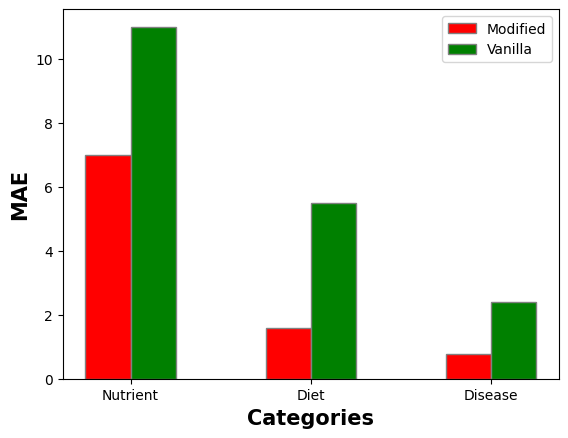

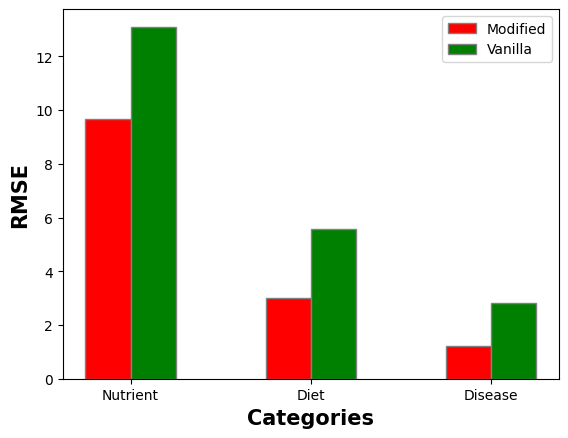

In [25]:
def get_values(df, col_name):
  col_values = []
  for value in df[col_name].values:
    col_values.extend(value.split())
  return col_values

user_df = pd.read_csv('/content/drive/MyDrive/project/Data_Recommendation/dataset.csv')
user_df = user_df[user_df['user_id']==user_id]

user_nutrient_list = get_values(user_df, 'nutrient')
user_diet_list = get_values(user_df, 'diet')
user_disease_list = get_values(user_df, 'disease')


predicted_nutrient_list = get_values(result, 'nutrient')
predicted_diet_list = get_values(result, 'diet')
predicted_disease_list = get_values(result, 'disease')

predicted_nutrient_list_vanilla = get_values(result_vanilla, 'nutrient')
predicted_diet_list_vanilla = get_values(result_vanilla, 'diet')
predicted_disease_list_vanilla = get_values(result_vanilla, 'disease')


# print(user_nutrient_list)
# print(predicted_nutrient_list)

# print(user_diet_list)
# print(predicted_diet_list)

# print(user_disease_list)
# print(predicted_disease_list)

def calculate_accuracy(p_list, u_list):
  u_list = list(set(u_list))
  p_list = list(set(p_list))

  count = 0
  for u in u_list:
    if u in p_list:
      count += 1
  return (count/len(u_list))*100
## calculate_accuracy(p_list, u_list) takes two lists (p_list for predicted values, u_list for user values), removes duplicates, 
## counts the common elements between the lists, and returns the accuracy as a percentage.


def calculate_accuracy_2(p_list, u_list):
  u_list = list(set(u_list))
  p_list = list(set(p_list))
  map = {}
  count = 1;
  for u in u_list: 
    map[u] = count
    count += 1

  for p in p_list:
    if p not in map:
      map[p] = count
      count += 1
  
  u_list2 = [map[u] for u in u_list]
  p_list2 = [map[p] for p in p_list]

  # create sample true and predicted values
  true_values = np.array(u_list2)
  pred_values = np.array(p_list2)

  # find common indices
  common_indices = np.intersect1d(np.arange(len(true_values)), np.arange(len(pred_values)))

  # extract common values
  true_values_common = true_values[common_indices]
  pred_values_common = pred_values[common_indices]

  # calculate MAE
  mae = np.mean(np.abs(true_values_common - pred_values_common))  
  # calculate RMSE
  rmse = np.sqrt(np.mean((true_values_common - pred_values_common) ** 2))

  return mae, rmse
## calculate_accuracy_2(p_list, u_list) takes two lists (p_list for predicted values, u_list for user values), 
## creates a mapping of unique values from both lists to integers, converts the original lists to the mapped values, 
## calculates the Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) between the mapped values, and returns the calculated MAE and RMSE.

nutrient_mae, nutrient_rmse = calculate_accuracy_2(predicted_nutrient_list, user_nutrient_list)
diet_mae, diet_rmse = calculate_accuracy_2(predicted_diet_list, user_diet_list)
disease_mae, disease_rmse = calculate_accuracy_2(predicted_disease_list, user_disease_list)

nutrient_mae_vanilla, nutrient_rmse_vanilla = calculate_accuracy_2(predicted_nutrient_list_vanilla, user_nutrient_list)
diet_mae_vanilla, diet_rmse_vanilla = calculate_accuracy_2(predicted_diet_list_vanilla, user_diet_list)
disease_mae_vanilla, disease_rmse_vanilla = calculate_accuracy_2(predicted_disease_list_vanilla, user_disease_list)


print(f"{'Mean Absolute Error of nutrient attributes':<50s}: {nutrient_mae:.2f}%")  
print(f"{'Mean Absolute Error of diet attributes':<50s}: {diet_mae:.2f}%")  
print(f"{'Mean Absolute Error of disease attributes':<50s}: {disease_mae:.2f}%")  
print()
print(f"{'Root Mean Squared Error of nutrient attributes':<50s}: {nutrient_rmse:.2f}%")  
print(f"{'Root Mean Squared Error of diet attributes':<50s}: {diet_rmse:.2f}%")  
print(f"{'Root Mean Squared Error of disease attributes':<50s}: {disease_rmse:.2f}%")  
print()
print()
print(f"{'Mean Absolute Error of nutrient attributes (Vanilla)':<50s}: {nutrient_mae_vanilla:.2f}%")  
print(f"{'Mean Absolute Error of diet attributes (Vanilla)':<50s}: {diet_mae_vanilla:.2f}%")  
print(f"{'Mean Absolute Error of disease attributes (Vanilla)':<50s}: {disease_mae_vanilla:.2f}%")  
print()
print(f"{'Root Mean Squared Error of nutrient attributes (Vanilla)':<50s}: {nutrient_rmse_vanilla:.2f}%")  
print(f"{'Root Mean Squared Error of diet attributes (Vanilla)':<50s}: {diet_rmse_vanilla:.2f}%")  
print(f"{'Root Mean Squared Error of disease attributes (Vanilla)':<50s}: {disease_rmse_vanilla:.2f}%")  
print()

barWidth = 0.25
 
# set height of bar
IT = [12, 30, 1, 8, 22]
ECE = [28, 6, 16, 5, 10]
 
# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, [nutrient_mae, diet_mae, disease_mae], color ='r', width = barWidth,
        edgecolor ='grey', label ='Modified')
plt.bar(br2, [nutrient_mae_vanilla, diet_mae_vanilla, disease_mae_vanilla], color ='g', width = barWidth,
        edgecolor ='grey', label ='Vanilla')
 
# Adding Xticks
plt.xlabel('Categories', fontweight ='bold', fontsize = 15)
plt.ylabel('MAE', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(3)],
        ['Nutrient', 'Diet', 'Disease'])
 
plt.legend()
plt.show()

print()

barWidth = 0.25
 
# set height of bar
IT = [12, 30, 1, 8, 22]
ECE = [28, 6, 16, 5, 10]
 
# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, [nutrient_rmse, diet_rmse, disease_rmse], color ='r', width = barWidth,
        edgecolor ='grey', label ='Modified')
plt.bar(br2, [nutrient_rmse_vanilla, diet_rmse_vanilla, disease_rmse_vanilla], color ='g', width = barWidth,
        edgecolor ='grey', label ='Vanilla')
 
# Adding Xticks
plt.xlabel('Categories', fontweight ='bold', fontsize = 15)
plt.ylabel('RMSE', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(3)],
        ['Nutrient', 'Diet', 'Disease'])
 
plt.legend()
plt.show()

BLEU-1 of nutrient attributes                     : 0.04
BLEU-1 of diet attributes                         : 0.50
BLEU-1 of disease attributes                      : 0.37

BLEU-1 of nutrient attributes (Vanilla)           : 0.00
BLEU-1 of diet attributes (Vanilla)               : 0.00
BLEU-1 of disease attributes (Vanilla)            : 0.02



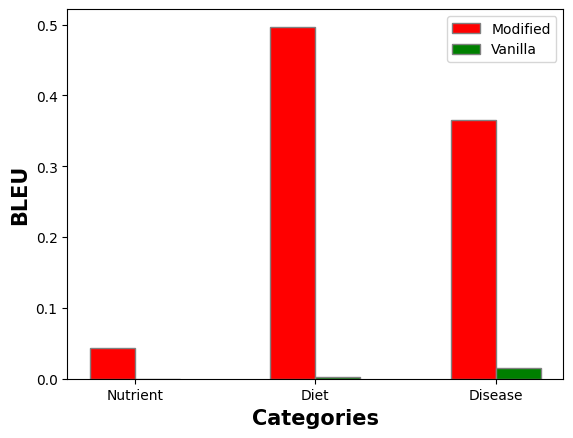

In [26]:
nutrient_bleu = nltk.translate.bleu_score.sentence_bleu([user_nutrient_list], predicted_nutrient_list, weights=(1,))
diet_bleu = nltk.translate.bleu_score.sentence_bleu([user_diet_list], predicted_diet_list, weights=(1,))
disease_bleu = nltk.translate.bleu_score.sentence_bleu([user_disease_list], predicted_disease_list, weights=(1,))

nutrient_bleu_vanilla = nltk.translate.bleu_score.sentence_bleu([user_nutrient_list], predicted_nutrient_list_vanilla, weights=(1,))
diet_bleu_vanilla = nltk.translate.bleu_score.sentence_bleu([user_diet_list], predicted_diet_list_vanilla, weights=(1,))
disease_bleu_vanilla = nltk.translate.bleu_score.sentence_bleu([user_disease_list], predicted_disease_list_vanilla, weights=(1,))

print(f"{'BLEU-1 of nutrient attributes':<50s}: {nutrient_bleu:.2f}")  
print(f"{'BLEU-1 of diet attributes':<50s}: {diet_bleu:.2f}")  
print(f"{'BLEU-1 of disease attributes':<50s}: {disease_bleu:.2f}")  
print()
print(f"{'BLEU-1 of nutrient attributes (Vanilla)':<50s}: {nutrient_bleu_vanilla:.2f}")  
print(f"{'BLEU-1 of diet attributes (Vanilla)':<50s}: {diet_bleu_vanilla:.2f}")  
print(f"{'BLEU-1 of disease attributes (Vanilla)':<50s}: {disease_bleu_vanilla:.2f}")  
print()

barWidth = 0.25
 
# set height of bar
IT = [12, 30, 1, 8, 22]
ECE = [28, 6, 16, 5, 10]
 
# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, [nutrient_bleu, diet_bleu, disease_bleu], color ='r', width = barWidth,
        edgecolor ='grey', label ='Modified')
plt.bar(br2, [nutrient_bleu_vanilla, diet_bleu_vanilla, disease_bleu_vanilla], color ='g', width = barWidth,
        edgecolor ='grey', label ='Vanilla')
 
# Adding Xticks
plt.xlabel('Categories', fontweight ='bold', fontsize = 15)
plt.ylabel('BLEU', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(3)],
        ['Nutrient', 'Diet', 'Disease'])
 
plt.legend()
plt.show()

GLEU of nutrient attributes                       : 0.16
GLEU of diet attributes                           : 0.53
GLEU of disease attributes                        : 0.47

GLEU of nutrient attributes                       : 0.06
GLEU of diet attributes                           : 0.14
GLEU of disease attributes                        : 0.19



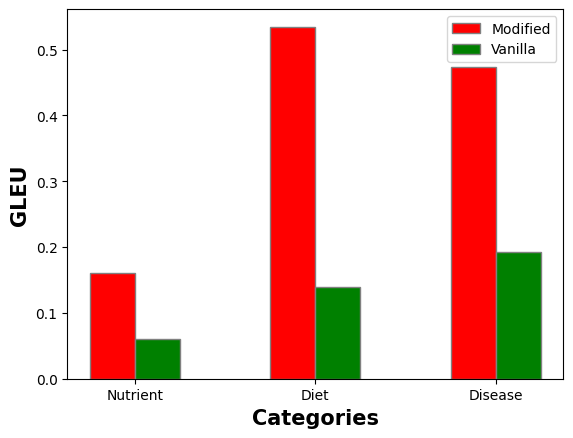

In [27]:
nutrient_gleu = nltk.translate.gleu_score.sentence_gleu([user_nutrient_list], predicted_nutrient_list, max_len=1)
diet_gleu = nltk.translate.gleu_score.sentence_gleu([user_diet_list], predicted_diet_list, max_len=1)
disease_gleu = nltk.translate.gleu_score.sentence_gleu([user_disease_list], predicted_disease_list, max_len=1)

nutrient_gleu_vanilla = nltk.translate.gleu_score.sentence_gleu([user_nutrient_list], predicted_nutrient_list_vanilla, max_len=1)
diet_gleu_vanilla = nltk.translate.gleu_score.sentence_gleu([user_diet_list], predicted_diet_list_vanilla, max_len=1)
disease_gleu_vanilla = nltk.translate.gleu_score.sentence_gleu([user_disease_list], predicted_disease_list_vanilla, max_len=1)

print(f"{'GLEU of nutrient attributes':<50s}: {nutrient_gleu:.2f}")  
print(f"{'GLEU of diet attributes':<50s}: {diet_gleu:.2f}")  
print(f"{'GLEU of disease attributes':<50s}: {disease_gleu:.2f}")  
print()
print(f"{'GLEU of nutrient attributes':<50s}: {nutrient_gleu_vanilla:.2f}")  
print(f"{'GLEU of diet attributes':<50s}: {diet_gleu_vanilla:.2f}")  
print(f"{'GLEU of disease attributes':<50s}: {disease_gleu_vanilla:.2f}") 
print()

barWidth = 0.25
 
# set height of bar
IT = [12, 30, 1, 8, 22]
ECE = [28, 6, 16, 5, 10]
 
# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, [nutrient_gleu, diet_gleu, disease_gleu], color ='r', width = barWidth,
        edgecolor ='grey', label ='Modified')
plt.bar(br2, [nutrient_gleu_vanilla, diet_gleu_vanilla, disease_gleu_vanilla], color ='g', width = barWidth,
        edgecolor ='grey', label ='Vanilla')
 
# Adding Xticks
plt.xlabel('Categories', fontweight ='bold', fontsize = 15)
plt.ylabel('GLEU', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(3)],
        ['Nutrient', 'Diet', 'Disease'])
 
plt.legend()
plt.show()

NIST of nutrient attributes                       : 0.00
NIST of diet attributes                           : 1.40
NIST of disease attributes                        : 0.51

NIST of nutrient attributes (Vanilla)             : 0.00
NIST of diet attributes (Vanilla)                 : 0.00
NIST of disease attributes (Vanilla)              : 0.00



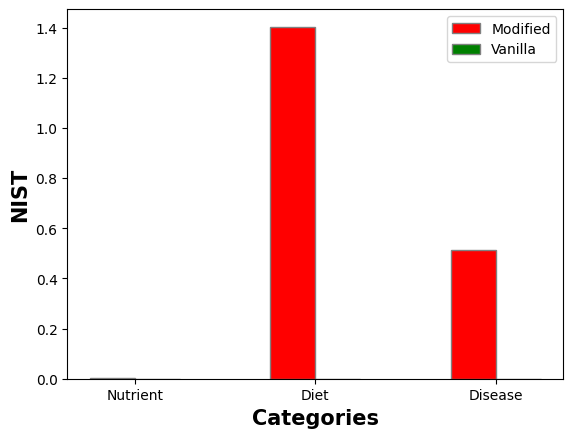

In [28]:
nutrient_nist = nltk.translate.nist_score.sentence_nist([user_nutrient_list], predicted_nutrient_list, n=1)
diet_nist = nltk.translate.nist_score.sentence_nist([user_diet_list], predicted_diet_list, n=1)
disease_nist = nltk.translate.nist_score.sentence_nist([user_disease_list], predicted_disease_list, n=1)

nutrient_nist_vanilla = nltk.translate.nist_score.sentence_nist([user_nutrient_list], predicted_nutrient_list_vanilla, n=1)
diet_nist_vanilla = nltk.translate.nist_score.sentence_nist([user_diet_list], predicted_diet_list_vanilla, n=1)
disease_nist_vanilla = nltk.translate.nist_score.sentence_nist([user_disease_list], predicted_disease_list_vanilla, n=1)

print(f"{'NIST of nutrient attributes':<50s}: {nutrient_nist:.2f}")  
print(f"{'NIST of diet attributes':<50s}: {diet_nist:.2f}")  
print(f"{'NIST of disease attributes':<50s}: {disease_nist:.2f}")  
print()
print(f"{'NIST of nutrient attributes (Vanilla)':<50s}: {nutrient_nist_vanilla:.2f}")  
print(f"{'NIST of diet attributes (Vanilla)':<50s}: {diet_nist_vanilla:.2f}")  
print(f"{'NIST of disease attributes (Vanilla)':<50s}: {disease_nist_vanilla:.2f}")  
print()

barWidth = 0.25
 
# set height of bar
IT = [12, 30, 1, 8, 22]
ECE = [28, 6, 16, 5, 10]
 
# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, [nutrient_nist, diet_nist, disease_nist], color ='r', width = barWidth,
        edgecolor ='grey', label ='Modified')
plt.bar(br2, [nutrient_nist_vanilla, diet_nist_vanilla, disease_nist_vanilla], color ='g', width = barWidth,
        edgecolor ='grey', label ='Vanilla')
 
# Adding Xticks
plt.xlabel('Categories', fontweight ='bold', fontsize = 15)
plt.ylabel('NIST', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(3)],
        ['Nutrient', 'Diet', 'Disease'])
 
plt.legend()
plt.show()

RIBES of nutrient attributes                      : 0.00
RIBES of diet attributes                          : 0.49
RIBES of disease attributes                       : 0.51

RIBES of nutrient attributes (Vanilla)            : 0.00
RIBES of diet attributes (Vanilla)                : 0.00
RIBES of disease attributes (Vanilla)             : 0.43



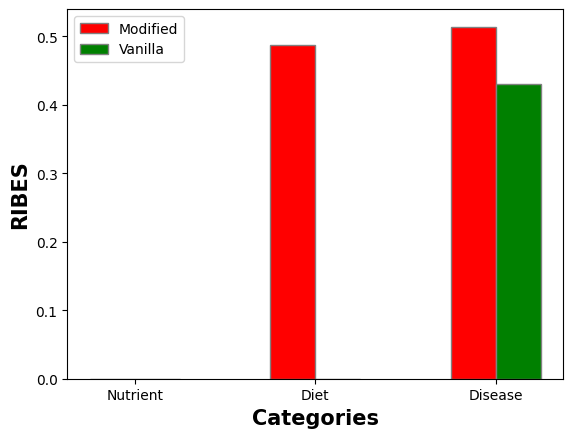

In [29]:
nutrient_ribes = nltk.translate.ribes_score.sentence_ribes([user_nutrient_list], predicted_nutrient_list)
diet_ribes = nltk.translate.ribes_score.sentence_ribes([user_diet_list], predicted_diet_list)
disease_ribes = nltk.translate.ribes_score.sentence_ribes([user_disease_list], predicted_disease_list)

nutrient_ribes_vanilla = nltk.translate.ribes_score.sentence_ribes([user_nutrient_list], predicted_nutrient_list_vanilla)
diet_ribes_vanilla = nltk.translate.ribes_score.sentence_ribes([user_diet_list], predicted_diet_list_vanilla)
disease_ribes_vanilla = nltk.translate.ribes_score.sentence_ribes([user_disease_list], predicted_disease_list_vanilla)

print(f"{'RIBES of nutrient attributes':<50s}: {nutrient_ribes:.2f}")  
print(f"{'RIBES of diet attributes':<50s}: {diet_ribes:.2f}")  
print(f"{'RIBES of disease attributes':<50s}: {disease_ribes:.2f}")  
print()
print(f"{'RIBES of nutrient attributes (Vanilla)':<50s}: {nutrient_ribes_vanilla:.2f}")  
print(f"{'RIBES of diet attributes (Vanilla)':<50s}: {diet_ribes_vanilla:.2f}")  
print(f"{'RIBES of disease attributes (Vanilla)':<50s}: {disease_ribes_vanilla:.2f}") 
print()

barWidth = 0.25
 
# set height of bar
IT = [12, 30, 1, 8, 22]
ECE = [28, 6, 16, 5, 10]
 
# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, [nutrient_ribes, diet_ribes, disease_ribes], color ='r', width = barWidth,
        edgecolor ='grey', label ='Modified')
plt.bar(br2, [nutrient_ribes_vanilla, diet_ribes_vanilla, disease_ribes_vanilla], color ='g', width = barWidth,
        edgecolor ='grey', label ='Vanilla')
 
# Adding Xticks
plt.xlabel('Categories', fontweight ='bold', fontsize = 15)
plt.ylabel('RIBES', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(3)],
        ['Nutrient', 'Diet', 'Disease'])
 
plt.legend()
plt.show() 